# Decision Tree

In [138]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

In [139]:
df_final = pd.read_csv('../data/processed/final.csv')
X = df_final.drop('result', axis=1)
y = df_final['result']

# MLFlow

In [140]:
import mlflow
import mlflow.sklearn
from pathlib import Path

In [141]:
MLFLOW_DIR = Path("../mlruns").resolve()
ARTIFACTS_DIR = Path("../configs/models").resolve()
mlflow.set_tracking_uri(f"file:///{str(MLFLOW_DIR)}")

In [142]:
BASE_EXPERIMENT_NAME = "Decision_Tree"

def set_experiment(experiment_name):
    experiment_name = f"{BASE_EXPERIMENT_NAME}_{experiment_name}"
    mlflow.set_experiment(experiment_name)

def create_experiment(experiment_name):
    experiment_name = f"{BASE_EXPERIMENT_NAME}_{experiment_name}"
    mlflow.create_experiment(experiment_name, artifact_location=f"file:///{str(ARTIFACTS_DIR)}")

In [143]:
def delete_experiment(experiment_name):
    experiment_name = f"{BASE_EXPERIMENT_NAME}_{experiment_name}"
    mlflow.delete_experiment(mlflow.get_experiment_by_name(experiment_name).experiment_id)

## Hyperparameter Tuning Libraries

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
import time

In [145]:
hpo_run_count = 14
kfc_run_count = 14

In [146]:
model = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [147]:
param_grid = {
    'max_depth': [3, 5, 7],  # Limit depth to prevent overfitting
    'min_samples_split': [2, 5, 10],  # Higher min_samples_split to prevent overfitting
    'min_samples_leaf': [1, 2, 4],  # Lower leaf samples to balance complexity
    'criterion': ['gini', 'entropy'],  # Criteria for splitting
    'splitter': ['best', 'random']  # Different methods of splitting nodes
}

# Set up GridSearchCV with F1-score
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [149]:
set_experiment("DT_GRIDSEARCH")

with mlflow.start_run(run_name=f"HPO_{hpo_run_count}_DT"):
    hpo_run_count += 1
    mlflow.log_param("model", "DecisionTreeClassifier")


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    
    best_score = grid_search.best_score_
    mlflow.log_metric("best_accuracy", best_score)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_precision", precision)
    mlflow.log_metric("test_recall", recall)
    mlflow.log_metric("test_f1", f1)

    class_report = classification_report(y_test, y_pred)
    mlflow.log_param("classification_report", class_report)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    cm_image_path = "./images/confusion_matrix.png"
    plt.savefig(cm_image_path)
    plt.close()

    mlflow.log_artifact(cm_image_path, "confusion_matrix")

    mlflow.sklearn.log_model(best_model, "model")

    print("Best parameters found: ", best_params)
    print("Best cross-validation accuracy: {:.4f}".format(best_score))
    print("Test Accuracy: {:.4f}".format(accuracy))
    print("Test Precision: {:.4f}".format(precision))
    print("Test Recall: {:.4f}".format(recall))
    print("Test F1-Score: {:.4f}".format(f1))
    print("\nClassification Report:\n", class_report)
    print("\nConfusion Matrix:\n", cm)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


2024/11/20 16:10:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best parameters found:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation accuracy: 0.9472
Test Accuracy: 0.9448
Test Precision: 0.9409
Test Recall: 0.9479
Test F1-Score: 0.9444

Classification Report:
               precision    recall  f1-score   support

          -1       0.95      0.94      0.95       412
           1       0.94      0.95      0.94       403

    accuracy                           0.94       815
   macro avg       0.94      0.94      0.94       815
weighted avg       0.94      0.94      0.94       815


Confusion Matrix:
 [[388  24]
 [ 21 382]]


# Kfold Cross Validation

In [150]:
best_params = grid_search.best_params_

In [151]:
set_experiment("DT_KFOLD")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_metric_data = []
metric_data = []
with mlflow.start_run(run_name=f"KFC_{kfc_run_count}_DT"):
    kfc_run_count += 1
    mlflow.log_param("model", "DecisionTreeClassifier")
    mlflow.log_param("cross_validation", "StratifiedKFold")
    
    for param, value in best_params.items():
        mlflow.log_param(param, value)

    best_model = None
    best_accuracy = 0

    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = DecisionTreeClassifier(random_state=21, **best_params)
        start_train_time = time.time()
        model.fit(X_train, y_train)
        end_train_time = time.time()

        mlflow.log_metric(f"train_time_{i}", end_train_time - start_train_time)

        y_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_pred)
        train_precision = precision_score(y_train, y_pred)
        train_recall = recall_score(y_train, y_pred)
        train_f1 = f1_score(y_train, y_pred)

        mlflow.log_metric(f"train_accuracy_{i}", train_accuracy)
        mlflow.log_metric(f"train_precision_{i}", train_precision)
        mlflow.log_metric(f"train_recall_{i}", train_recall)
        mlflow.log_metric(f"train_f1_{i}", train_f1)

        train_metric_data.append([train_accuracy, train_precision, train_recall, train_f1, end_train_time - start_train_time])

        start_test_time = time.time()
        y_pred = model.predict(X_test)
        end_test_time = time.time()

        mlflow.log_metric(f"test_time_{i}", end_test_time - start_test_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        mlflow.log_metric(f"test_accuracy_{i}", accuracy)
        mlflow.log_metric(f"test_precision_{i}", precision)
        mlflow.log_metric(f"test_recall_{i}", recall)
        mlflow.log_metric(f"test_f1_{i}", f1)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

        metric_data.append([accuracy, precision, recall, f1, end_test_time - start_test_time])

    mlflow.sklearn.log_model(best_model, "model")

    train_metric_data = np.array(train_metric_data)
    mean = np.mean(train_metric_data, axis=0)
    std = np.std(train_metric_data, axis=0)

    mlflow.log_metric("train_mean_accuracy", mean[0])
    mlflow.log_metric("train_mean_precision", mean[1])
    mlflow.log_metric("train_mean_recall", mean[2])
    mlflow.log_metric("train_mean_f1", mean[3])
    mlflow.log_metric("train_mean_time", mean[4])

    mlflow.log_metric("train_std_accuracy", std[0])
    mlflow.log_metric("train_std_precision", std[1])
    mlflow.log_metric("train_std_recall", std[2])
    mlflow.log_metric("train_std_f1", std[3])
    mlflow.log_metric("train_std_time", std[4])

    metric_data = np.array(metric_data)
    mean = np.mean(metric_data, axis=0)
    std = np.std(metric_data, axis=0)

    mlflow.log_metric("test_mean_accuracy", mean[0])
    mlflow.log_metric("test_mean_precision", mean[1])
    mlflow.log_metric("test_mean_recall", mean[2])
    mlflow.log_metric("mean_f1", mean[3])
    mlflow.log_metric("test_mean_time", mean[4])

    mlflow.log_metric("test_std_accuracy", std[0])
    mlflow.log_metric("test_std_precision", std[1])
    mlflow.log_metric("test_std_recall", std[2])
    mlflow.log_metric("test_std_f1", std[3])
    mlflow.log_metric("test_std_time", std[4])

2024/11/20 16:10:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Summary

In [152]:
train_metric_data = np.array(train_metric_data)
train_mean = np.mean(train_metric_data, axis=0)
train_std = np.std(train_metric_data, axis=0)

train_mean_accuracy, train_mean_precision, train_mean_recall, train_mean_f1, train_mean_time = train_mean
train_std_accuracy, train_std_precision, train_std_recall, train_std_f1, train_std_time = train_std

metric_data = np.array(metric_data)
test_mean = np.mean(metric_data, axis=0)
test_std = np.std(metric_data, axis=0)

test_mean_accuracy, test_mean_precision, test_mean_recall, test_mean_f1, test_mean_time = test_mean
test_std_accuracy, test_std_precision, test_std_recall, test_std_f1, test_std_time = test_std

headers = ["Metric", "Train Mean", "Train Std", "Test Mean", "Test Std"]
table_data = [
    ["Accuracy", train_mean_accuracy, train_std_accuracy, test_mean_accuracy, test_std_accuracy],
    ["Precision", train_mean_precision, train_std_precision, test_mean_precision, test_std_precision],
    ["Recall", train_mean_recall, train_std_recall, test_mean_recall, test_std_recall],
    ["F1 Score", train_mean_f1, train_std_f1, test_mean_f1, test_std_f1],
    ["Time (s)", train_mean_time, train_std_time, test_mean_time, test_std_time]
]

fancy_table = tabulate(table_data, headers=headers, tablefmt="fancy_grid", floatfmt=".4f")

print(fancy_table)

╒═══════════╤══════════════╤═════════════╤═════════════╤════════════╕
│ Metric    │   Train Mean │   Train Std │   Test Mean │   Test Std │
╞═══════════╪══════════════╪═════════════╪═════════════╪════════════╡
│ Accuracy  │       0.9631 │      0.0028 │      0.9474 │     0.0070 │
├───────────┼──────────────┼─────────────┼─────────────┼────────────┤
│ Precision │       0.9482 │      0.0198 │      0.9338 │     0.0170 │
├───────────┼──────────────┼─────────────┼─────────────┼────────────┤
│ Recall    │       0.9777 │      0.0184 │      0.9597 │     0.0249 │
├───────────┼──────────────┼─────────────┼─────────────┼────────────┤
│ F1 Score  │       0.9623 │      0.0025 │      0.9462 │     0.0077 │
├───────────┼──────────────┼─────────────┼─────────────┼────────────┤
│ Time (s)  │       0.0048 │      0.0038 │      0.0014 │     0.0010 │
╘═══════════╧══════════════╧═════════════╧═════════════╧════════════╛


In [153]:
total_test = best_model.predict(X_test)
print(classification_report(y_test, total_test))

              precision    recall  f1-score   support

          -1       0.98      0.94      0.96       422
           1       0.94      0.98      0.96       392

    accuracy                           0.96       814
   macro avg       0.96      0.96      0.96       814
weighted avg       0.96      0.96      0.96       814



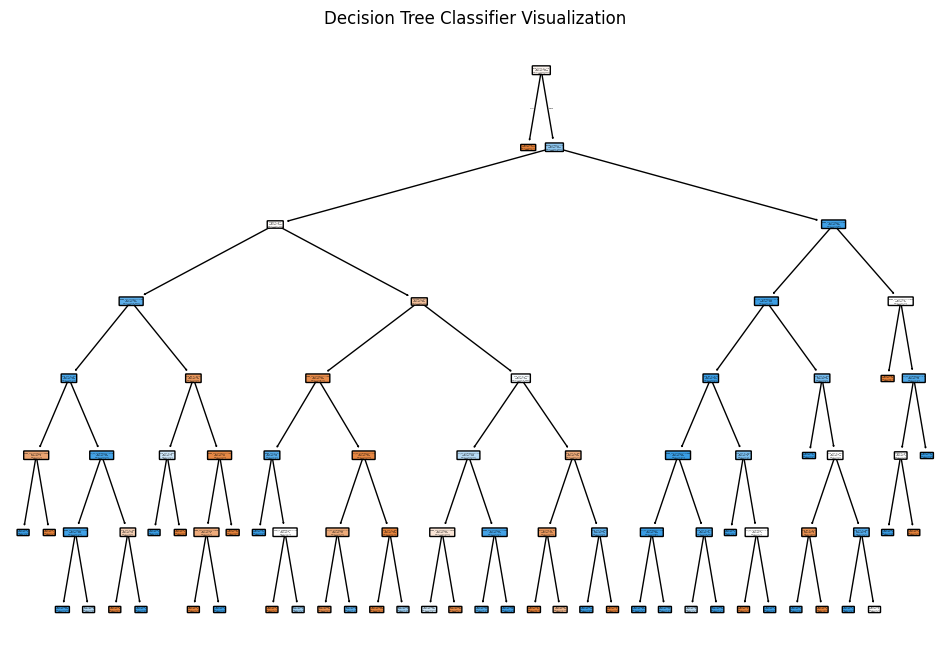

In [154]:
plt.figure(figsize=(12, 8))
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=[str(label) for label in y.unique()], rounded=True)
plt.title("Decision Tree Classifier Visualization")
plt.show()